# GRU

1. Wprowadzenie do sieci GRU
2. Import bibliotek
3. Baza danych
4. Wstępna analiza tekstu
5. Modele treningowe (poszukiwanie optymalnego rozwiązania)
6. Praca na modelu
7. Analiza sentymentu
8. Podsumowanie

1. Wprowadzenie do sieci GRU

Bramkowana jednostka rekurencyjna (GRU) to rodzaj rekurencyjnej sieci neuronowej (RNN), który został wprowadzony w 2014 r. jako prostsza alternatywa dla sieci długoterminowej pamięci krótkotrwałej (LSTM). Podobnie jak LSTM, GRU może przetwarzać dane sekwencyjne, takie jak tekst, mowa i dane szeregów czasowych.

Podstawową ideą GRU jest wykorzystanie mechanizmów bramkujących do selektywnej aktualizacji ukrytego stanu sieci w każdym kroku czasowym. Mechanizmy bramkujące służą do kontrolowania przepływu informacji do i z sieci. GRU ma dwa mechanizmy bramkujące, zwane bramką resetowania i bramką aktualizacji.

Bramka resetowania określa, jaka część poprzedniego stanu ukrytego powinna zostać zapomniana, natomiast bramka aktualizacji określa, jaka część nowego wejścia powinna zostać wykorzystana do aktualizacji stanu ukrytego. Dane wyjściowe GRU są obliczane na podstawie zaktualizowanego stanu ukrytego.

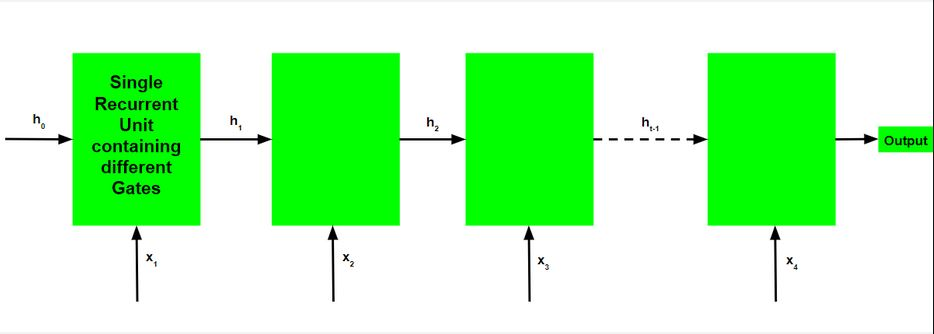

2. Import bibliotek

In [1]:
import pandas as pd
import numpy as np


!pip install -q tensorflow
!pip install -q spacy
!python -m spacy download en_core_web_md -q
!pip install Wordcloud -q
!pip install accelerate -q
!pip install transformers -q
!pip install datasets -q

import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
import tensorflow as tf

from wordcloud import WordCloud, STOPWORDS

from tqdm import tqdm
tqdm.pandas()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, f1_score, roc_curve

from tensorflow.keras.layers import GRU, LSTM, SimpleRNN, Embedding, Dropout
from tensorflow.keras.layers import Activation, Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D

from keras.models import Sequential

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

from torchtext.data.utils import get_tokenizer
from torch.utils.data import random_split
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import time

import en_core_web_sm

2023-12-27 10:51:40.846773: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-27 10:51:40.846825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-27 10:51:40.852201: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-27 10:51:40.871929: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-27 10:51:42.906057: W tensorflow/compiler/tf2

In [2]:
!pip install -U accelerate==0.20.3 -q
import accelerate
!pip install transformers -q
import transformers

#!pip install accelerate -U -q

3. Baza danych

Baza danych pochodzi z zasobów kaggle i znajduje się pod linkiem:
https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews

Baza obejmuje 20 491 recenzje klientów dotyczących hoteli, z których skorzystali. Rating w skali 1 - 5 z dominacją 4 i 5.

In [3]:
# Dane umieściłam na google drive, skąd je pobieram

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/tripadvisor_hotel_reviews.csv'
row_data = pd.read_csv(path)
row_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [4]:
# Zamieniam Rating na 3 klasy

row_data['Rating_class'] = row_data['Rating'].replace({5: 'Positive', 4: 'Positive', 3: 'Neutral',
                                                      2:'Negative', 1:'Negative'})
row_data

,Review,Rating,Rating_class
0,nice hotel expensive parking got good deal sta...,4,Positive
1,ok nothing special charge diamond member hilto...,2,Negative
2,nice rooms not 4* experience hotel monaco seat...,3,Neutral
3,"unique, great stay, wonderful time hotel monac...",5,Positive
4,"great stay great stay, went seahawk game aweso...",5,Positive
...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,Positive
20487,great location price view hotel great quick pl...,4,Positive
20488,"ok just looks nice modern outside, desk staff ...",2,Negative
20489,hotel theft ruined vacation hotel opened sept ...,1,Negative


In [5]:
# Tworzę kopię danych

data = row_data.copy()
del data['Rating']

4. Wstępna analiza tekstu

Przechodze do analizy tekstu dotyczącej m.in identyfikacji każdej z 3 grup klientów, stworzenia WordCloud na podstawie wcześniej zdefiniowanej próbki.
Definiuję funkcję remove_stopwords w celu usunięcia słów takich jak 'the' czy 'and' oraz uruchamiam proces lematyzacji w celu ujednolicenia odmiany słów.

In [6]:
data.shape

(20491, 2)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review        20491 non-null  object
 1   Rating_class  20491 non-null  object
dtypes: object(2)
memory usage: 320.3+ KB


In [8]:
data.groupby('Rating_class').nunique()

,Review
Rating_class,
Negative,3214
Neutral,2184
Positive,15093


<Axes: xlabel='Rating_class', ylabel='count'>

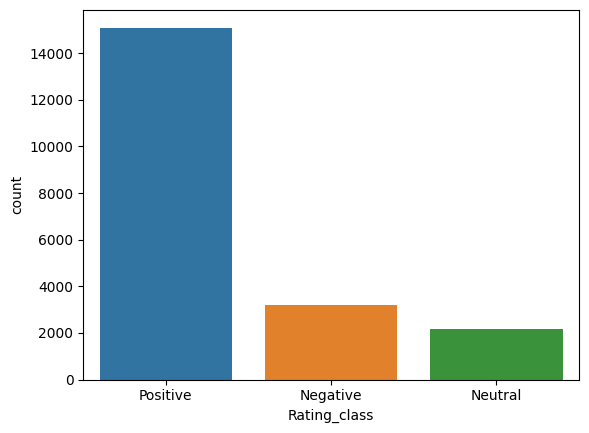

In [9]:
sns.countplot(x='Rating_class', data=data)

In [10]:
data['Review'] = data['Review'].apply(lambda x: x.lower())
data.sample(10)

,Review,Rating_class
4812,enjoyable london experience real just returned...,Positive
2422,no worries stayed hotel 10/31/05 11/6/05 booke...,Neutral
270,favorite hotel work responsibilities taken sea...,Positive
860,"amazing place amazing location amazing food, p...",Positive
2038,disappointing husband stayed doubltree april m...,Negative
1971,"wonderful, let tell place, 3 friends stayed ap...",Positive
8086,nice hotel husband spent seven nights hotel de...,Positive
16948,"maybe just unlucky, ok maybe just unlucky stay...",Negative
4300,"wonderful experience hotel lived expectations,...",Positive
20369,"charming hotel stayed 5 nights loved, nice hot...",Positive


In [11]:
import spacy

nlp = spacy.load('en_core_web_md', disable=['ner', 'parser'])
nlp.add_pipe('sentencizer')

In [12]:
def remove_stopwords(text):
  return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

data['Review'] = data['Review'].apply(remove_stopwords)
data.sample(10)

,Review,Rating_class
18242,"phenomenal place, best kept secrets waikiki be...",Positive
11386,loved manny santiago family stayed twice las c...,Positive
6494,pleasantly surprised having read promising rev...,Neutral
12061,"great views stayed nights higher floors, view ...",Positive
1560,"best looked reviews hotels san francisco, like...",Positive
17945,"absolutely spectacular, husband arrived ocean ...",Positive
8565,expected better stayed wife teenage children n...,Neutral
18709,loved melasti beach resort suite room fault se...,Positive
16904,great location stayed night bit pricey travele...,Positive
4916,perfect location perfect hotel husband returne...,Positive


In [13]:
data.drop_duplicates(subset='Review', keep='first', inplace=True)

In [14]:
a=data[data['Rating_class']== 'Positive'].sample(1000)
b=data[data['Rating_class']== 'Neutral'].sample(1000)
c=data[data['Rating_class']== 'Negative'].sample(1000)

data5k = pd.concat([a,b,c])

In [15]:
def lemmatize(text):
  return ' '.join([x.lemma_ for x in nlp(text)])

data5k['Review'] = data5k['Review'].progress_apply(lemmatize)
data5k.sample(10)

100%|██████████| 3000/3000 [00:45<00:00, 66.01it/s] 


,Review,Rating_class
19881,"great hotel hotel great probably stay , issue ...",Positive
7451,"stay away , family stay hotel week , want hono...",Negative
2491,"well stay 3 night honeymoon , hotel great loca...",Neutral
1115,great service daughter stay omni ny 5 night st...,Positive
11837,"overrate shabby , price room decent hotel room...",Negative
14276,"great experience , husband stay hotel neri 2 n...",Positive
14292,rate special location positiveshotel clean gre...,Negative
7284,nice hotel ghetto week go boston 2 sox game ho...,Negative
4101,nice place bad manager wrong bad people manage...,Negative
12224,"disappointed stay time recommend time , modern...",Neutral


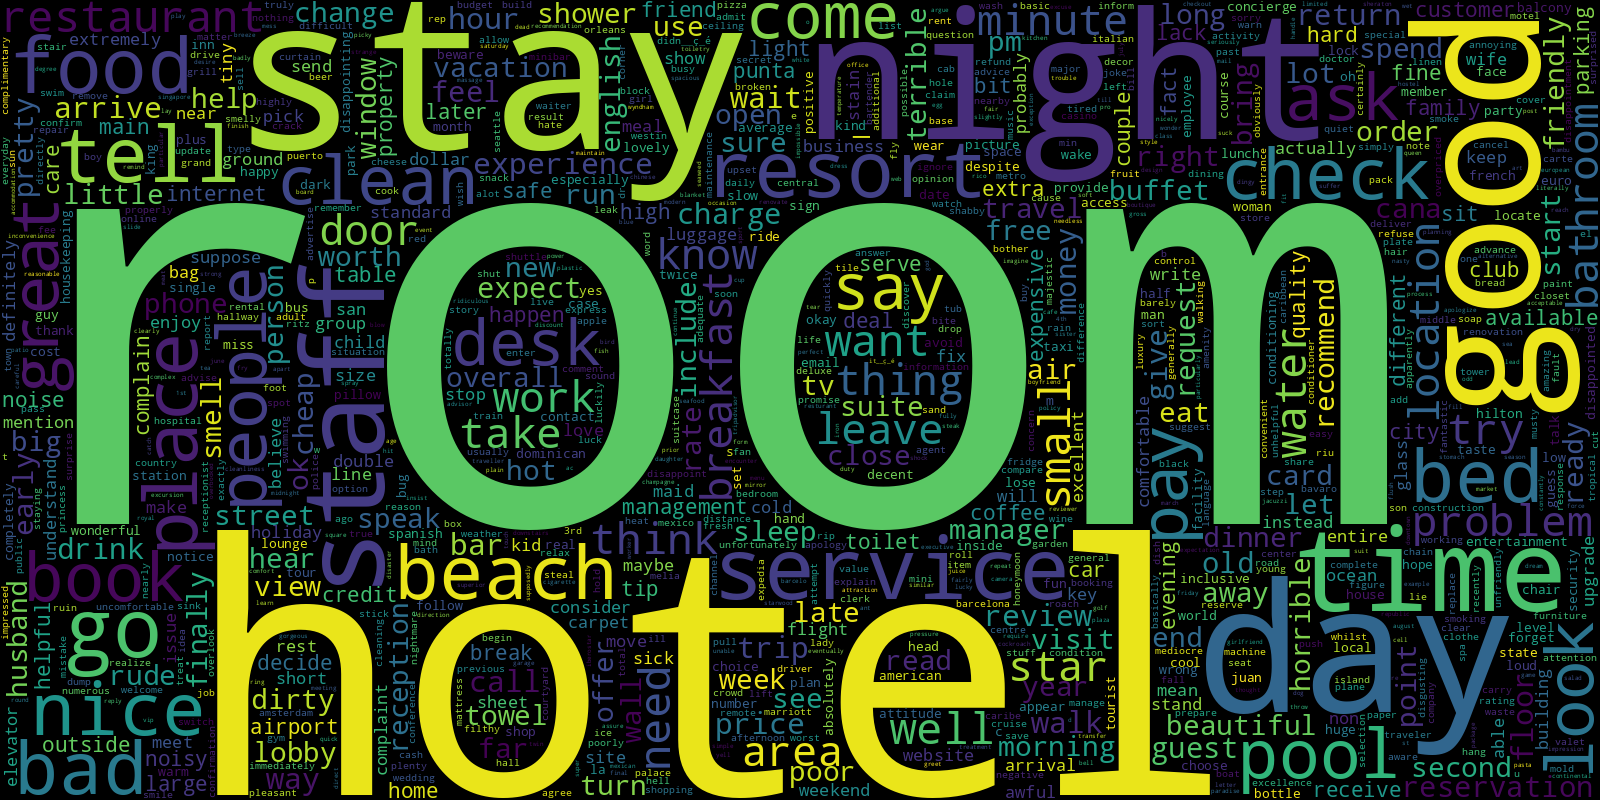

In [16]:
text_neg = ' '.join(data5k[data5k['Rating_class']== 'Negative']['Review'])

wc_neg = WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(text_neg)
wc_neg.to_image()

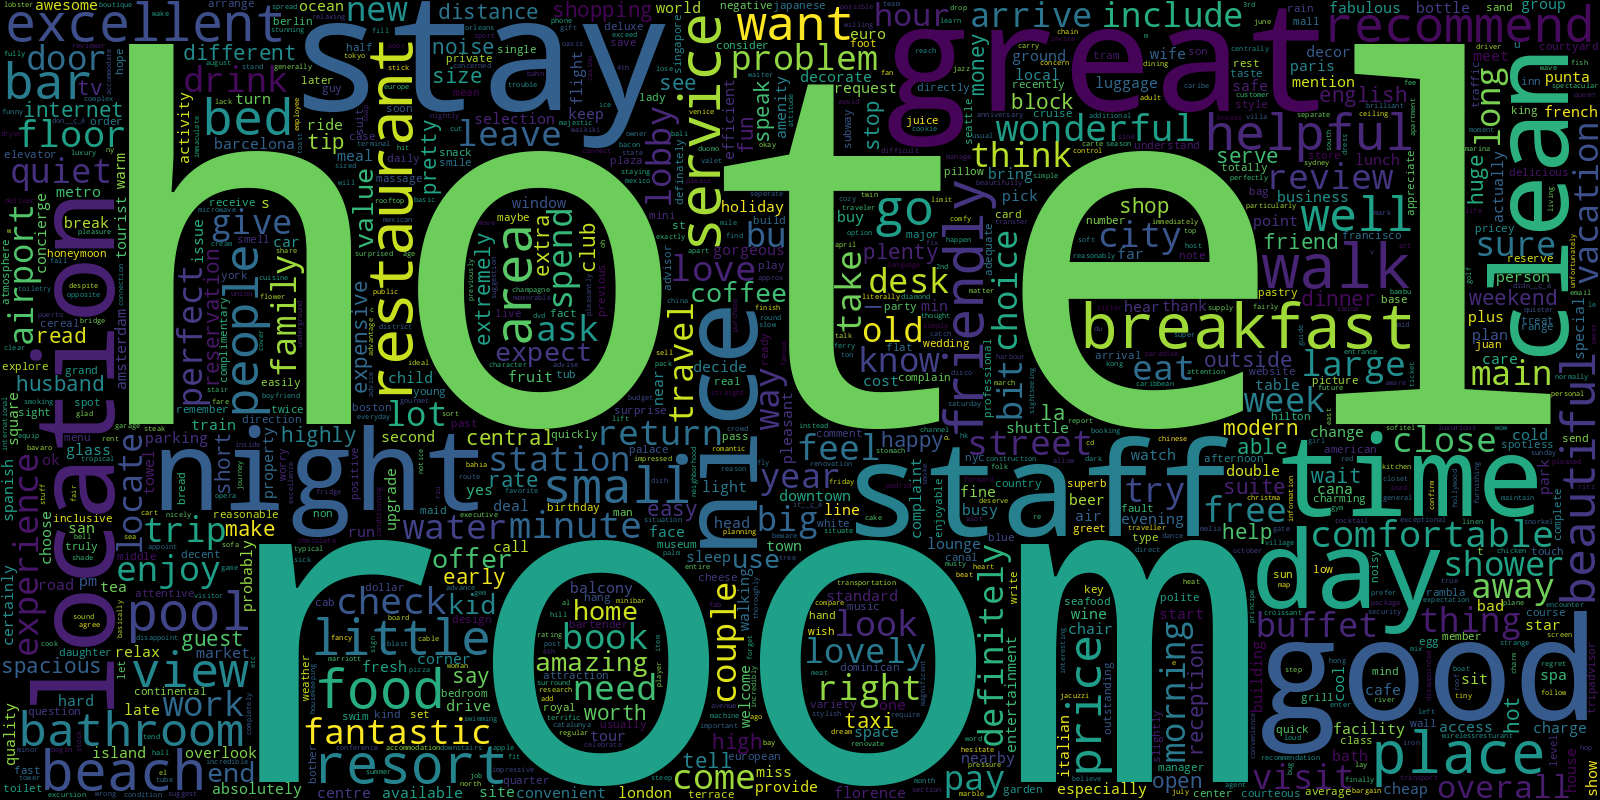

In [17]:
text_pos = ' '.join(data5k[data5k['Rating_class']== 'Positive']['Review'])

wc_pos = WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(text_pos)
wc_pos.to_image()

In [18]:
# Klasyfikacja

# Metoda train_test_split: 10% test, 90% train

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data5k.Review, data5k.Rating_class, test_size=0.1, stratify=data5k.Rating_class)

In [20]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
vectorizer.fit(X_train)

TfidfVectorizer(max_features=1000, ngram_range=(1, 2))

In [21]:
len(vectorizer.get_feature_names_out())

1000

In [22]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [23]:
print(X_train.shape)
print(X_test.shape)

(2700, 1000)
(300, 1000)


In [24]:
model = BernoulliNB()
model.fit(X_train, y_train)

BernoulliNB()

In [25]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.72      0.73      0.72       100
     Neutral       0.52      0.38      0.44       100
    Positive       0.58      0.73      0.65       100

    accuracy                           0.61       300
   macro avg       0.61      0.61      0.60       300
weighted avg       0.61      0.61      0.60       300



5. Modele treningowe (poszukiwanie optymalnego rozwiązania)

Poniżej prezentuje wyniki analizy na podstawie wcześniej przygotowanych modeli. Załączam modele oraz wykresy obrazujące val_loss i val_accuracy.
Moim celem było znalezienie modelu, dla którego val_accuracy będzie najwyższe przy jednoczesnym jak najniższym val_loss przed epoch, w której dochodzi do przeuczenia modelu.

In [26]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

Model 1 obejmuje jedną wartswę GRU bez Dropout, najwyższa wartośc val_accuracy występuje w 3 epoch (val_loss: 0.9675 - val_accuracy: 0.5567), po czym występuje przeuczenie modelu.

In [27]:
model = None
r = None

model = load_model('model_single_GRU.h5')

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 845)]             0         
                                                                 
 embedding (Embedding)       (None, 845, 20)           334960    
                                                                 
 gru (GRU)                   (None, 845, 128)          57600     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 392947 (1.50 MB)
Trainable params: 392947 (1.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________

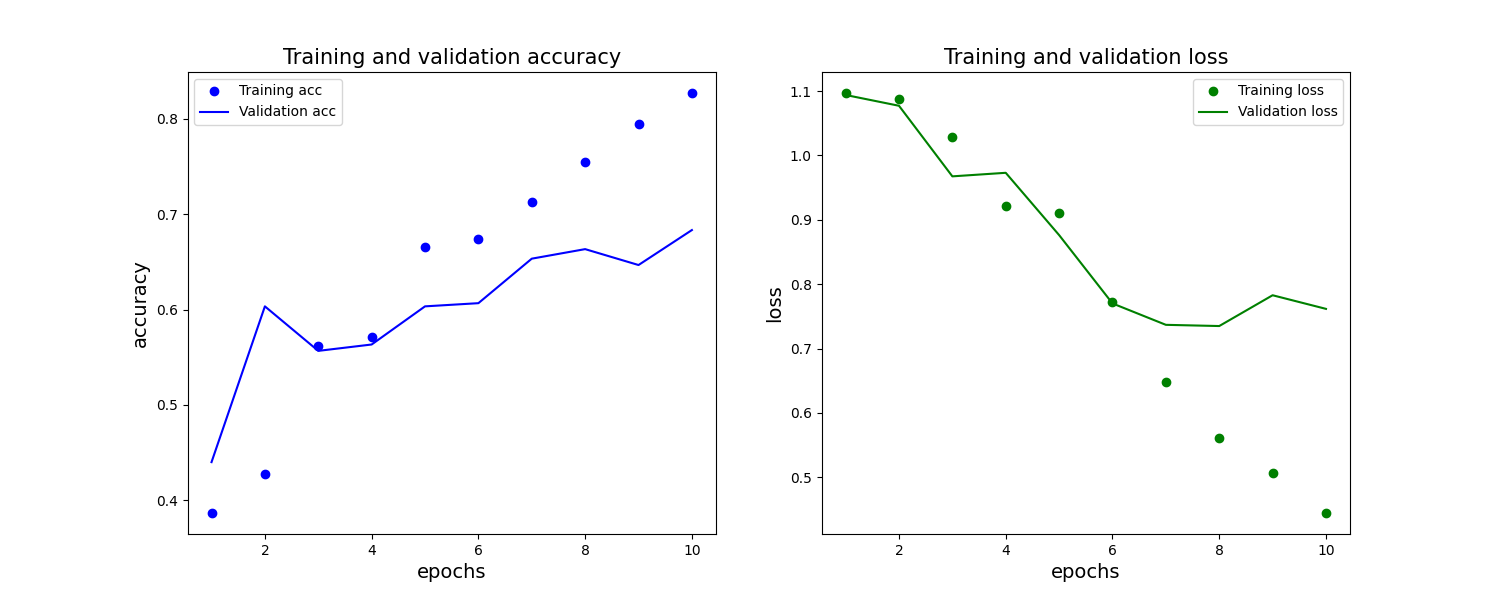

In [29]:
import PIL
from PIL import Image

fp = 'model_single_GRU.png'
PIL.Image.open(fp, mode='r', formats=None)

In [ ]:
model.get_config()

Model 2 obejmuje stworzenie 3 warstw GRU wraz z Dropout, najwyższa wartość val_acuracy występuje w 3 epoch (val_loss: 0.7922 - val_accuracy: 0.6000), następne model sie przeucza.

In [31]:
model = None
r = None

model = load_model('model_3GRU.h5')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 845)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 845, 20)           334960    
                                                                 
 gru_1 (GRU)                 (None, 845, 128)          57600     
                                                                 
 dropout (Dropout)           (None, 845, 128)          0         
                                                                 
 gru_2 (GRU)                 (None, 845, 128)          99072     
                                                                 
 dropout_1 (Dropout)         (None, 845, 128)          0         
                                                                 
 gru_3 (GRU)                 (None, 845, 128)          9907

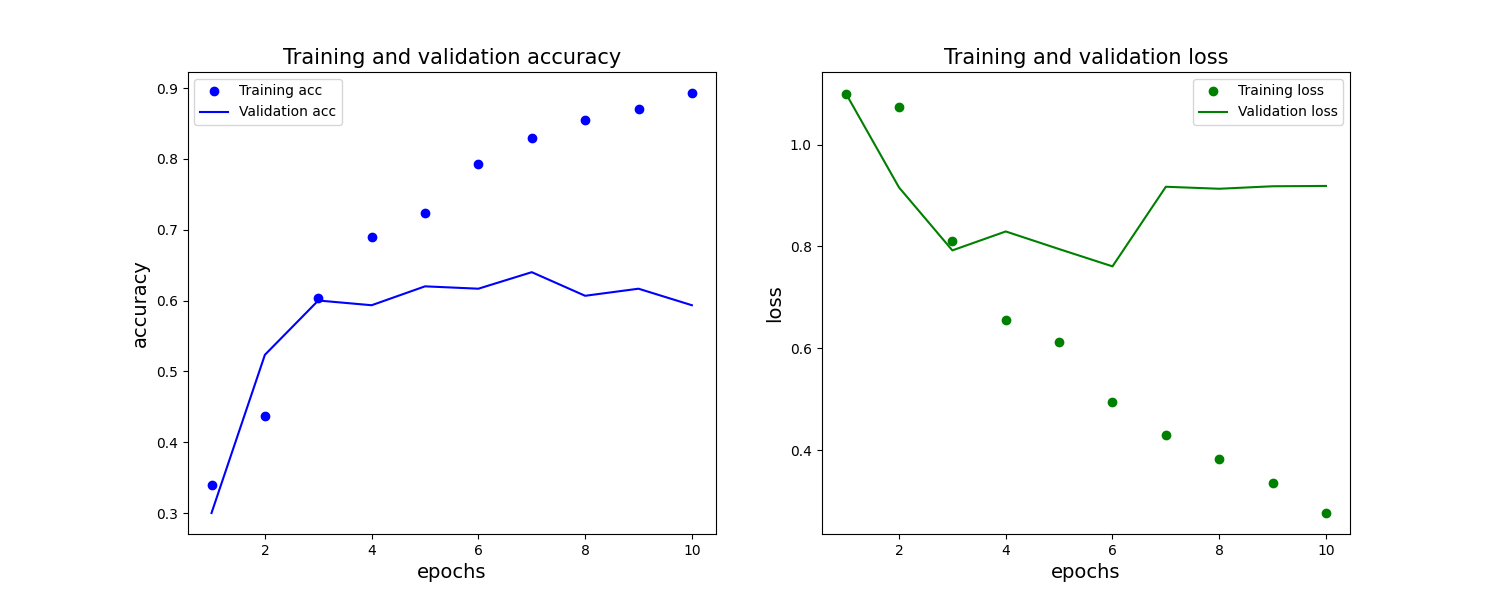

In [32]:
fp = 'model_3GRU.png'
PIL.Image.open(fp, mode='r', formats=None)

In [ ]:
model.get_config()

Model 3 to siec dwukierunkowa GRU z trzema warstwami Bidirectional GRU oraz Dropout. Wynik działania sieci to val_loss: 0.7294 - val_accuracy: 0.6567 w 4 epoch.

In [34]:
model = None
r = None

model = load_model('model_BiGRU.h5')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 845)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 845, 20)           334960    
                                                                 
 bidirectional (Bidirection  (None, 845, 256)          115200    
 al)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 845, 256)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 845, 256)          296448    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 845, 256)          0   

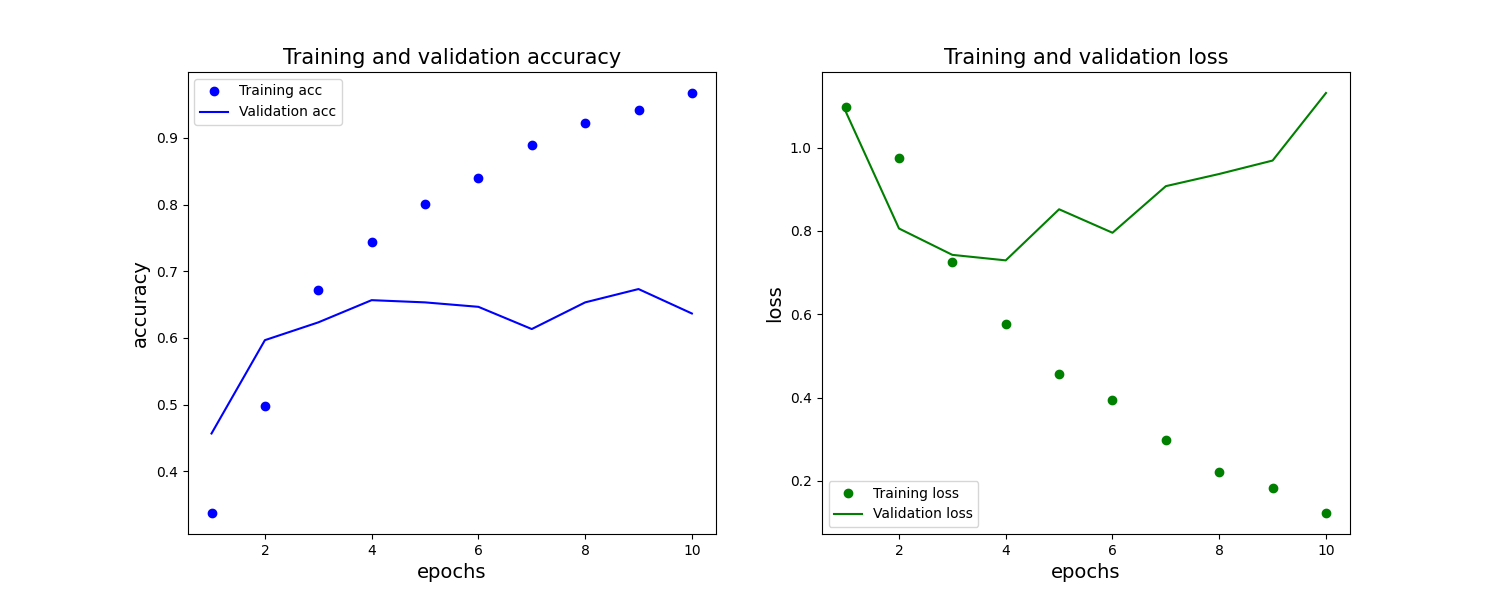

In [35]:
fp = 'model_BiGRU.png'
PIL.Image.open(fp, mode='r', formats=None)

In [ ]:
model.get_config()

Model 4 to sieć z pojedynczą warstwą Bidirectional GRU bez Dropout. Wynikiem działania sieci jest val_loss: 0.9912 - val_accuracy: 0.6567 w epoch 3, natomiast jest to siec bardzo niestabilna, dlatego nie będzie brana dalej pod uwagę.

In [37]:
model = None
r = None

model = load_model('model_single_BiGRU.h5')
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 845)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 845, 20)           334960    
                                                                 
 bidirectional_3 (Bidirecti  (None, 845, 256)          115200    
 onal)                                                           
                                                                 
 global_max_pooling1d_3 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 450931 (1.72 MB)
Trainable params: 450931 (1.

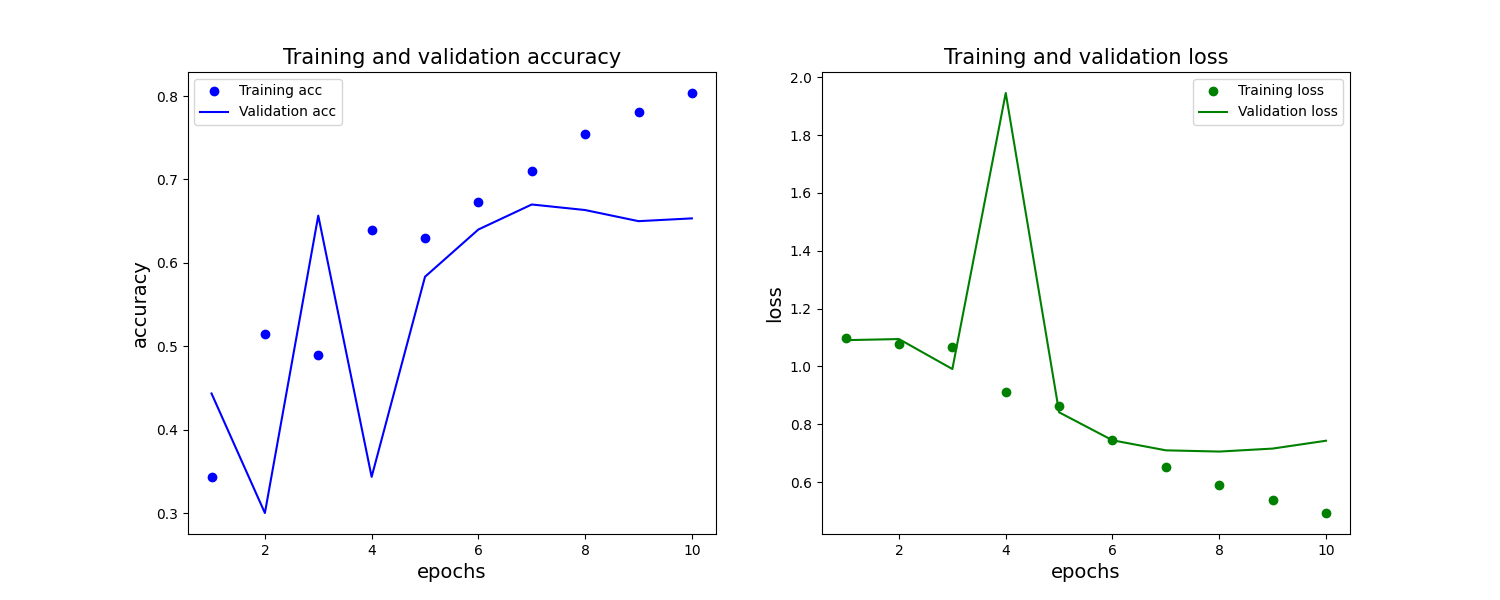

In [38]:
fp = 'model_single_BiGRU.png'
PIL.Image.open(fp, mode='r', formats=None)

In [ ]:
model.get_config()

Model 5 to sieć z pojedynczą warstwą Bidirectional GRU z Dropout. Wynikiem działania sieci jest val_loss: 1.0149 - val_accuracy: 0.6600 w epoch 4.

In [40]:
model = None
r = None

model = load_model('model_single_BiGRU_Dropout.h5')
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 845)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 845, 20)           334960    
                                                                 
 bidirectional_4 (Bidirecti  (None, 845, 256)          115200    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 845, 256)          0         
                                                                 
 global_max_pooling1d_4 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 3)                 771 

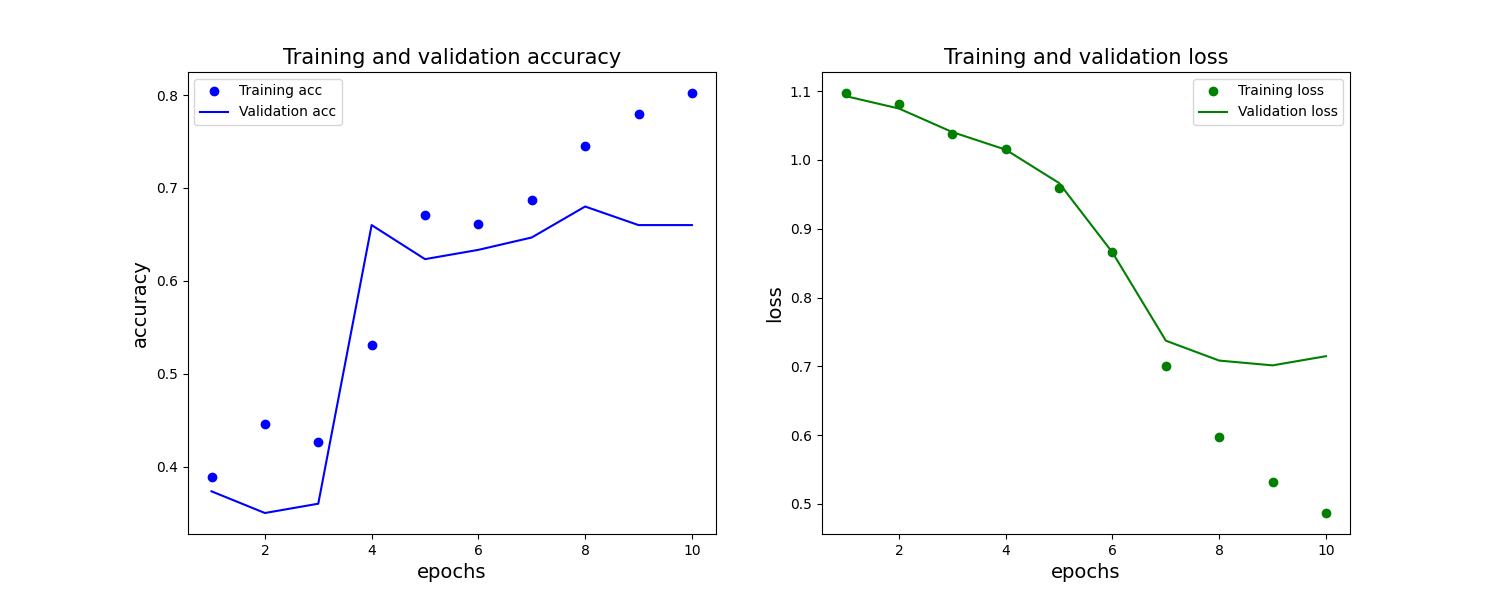

In [41]:
fp = 'model_single_BiGRU_Dropout.png'
PIL.Image.open(fp, mode='r', formats=None)

In [ ]:
model.get_config()

Podsumowanie modeli

Po przeanalizowaniu 5 wybranych modeli, najniższy wskaźnik val_loss: 0.7294 przy najwyższym val_accuracy: 0.6567 odnotowałam w epoce 4 w modelu 3 zawierającym 3 warstwy Bidirectional GRU wraz z Dropout. Sieć wygląda również na w miarę stabilną, dlatego wybrałam ją do dalszej analizy.

Uwaga: parametry modeli zostały dobrane w taki sposób, aby mogły zostać przeprocesowane przez środowisko wykonawcze google colab. Przy doborze innych parametrów środowisko rozłączało się. Zakładam, że osiągnięte wyniki mogłyby być lepsze dla mocniejszego środowiska.

In [43]:
import plotly.graph_objects as go

6. Praca na modelu

Ponieważ model osiągnął najwyższy wynik na epoch 4, dlatego zawężam jego działanie do tego poziomu. Poniżej przechodze ponownie kroki utworzenia modelu.

Budowa modelu:

model = None

r = None

D = 20



Sposób 1:

---


model = Sequential()

model.add(Embedding(V+1,D))

model.add(Bidirectional(GRU(128, return_sequences = True, activation='tanh')))

model.add(Dropout(0.2))

model.add(Bidirectional(GRU(128, return_sequences = True, activation='tanh')))

model.add(Dropout(0.2))

model.add(Bidirectional(GRU(128, return_sequences = True, activation='tanh')))

model.add(Dropout(0.2))

model.add(GlobalMaxPooling1D())

model.add(Dense(K))

model.summary()

Sposób 2:

---

i = Input(shape = (T,))

x = Embedding(V + 1, D)(i)

x = GRU(128, return_sequences = True, activation='tanh')(x)

x = Dropout(0.2)(x)

x = GRU(128, return_sequences = True, activation='tanh')(x)

x = Dropout(0.2)(x)

x = GRU(128, return_sequences = True, activation='tanh')(x)

x = Dropout(0.2)(x)

x = GlobalMaxPooling1D()(x)

x = Dense(K)(x)


model = Model(i,x)

In [44]:
!pip install -U portalocker>=2.0.0 -q
!pip install torchtext -q

In [45]:
tokenizer = get_tokenizer('spacy', 'en_core_web_sm')

def yield_tokens(data_iter):
  for _, text in data_iter:
    yield tokenizer(text)

In [46]:
data5k.head()

,Review,Rating_class
1444,perfect stay great time stay adolphus new year...,Positive
9306,"great hotel , spend 3 night nh duc barcelona l...",Positive
17582,faultless good value v. central location immac...,Positive
12339,"great location good value , stay victoria cour...",Positive
6768,"honest review- read , return country resort , ...",Positive


In [47]:
def lemmatize(text):
  return ' '.join([x.lemma_ for x in nlp(text)])

data5k['Review'] = data5k['Review'].progress_apply(lemmatize)
data5k.head()

100%|██████████| 3000/3000 [00:45<00:00, 66.16it/s] 


,Review,Rating_class
1444,perfect stay great time stay adolphus new year...,Positive
9306,"great hotel , spend 3 night nh duc barcelona l...",Positive
17582,faultless good value v. central location immac...,Positive
12339,"great location good value , stay victoria cour...",Positive
6768,"honest review- read , return country resort , ...",Positive


In [48]:
data5k['Rating_class'] = data5k['Rating_class'].replace({'Positive':3, 'Neutral':2,
                                                      'Negative': 1})
data5k.head()

,Review,Rating_class
1444,perfect stay great time stay adolphus new year...,3
9306,"great hotel , spend 3 night nh duc barcelona l...",3
17582,faultless good value v. central location immac...,3
12339,"great location good value , stay victoria cour...",3
6768,"honest review- read , return country resort , ...",3


In [49]:
data5k['targets'] = data5k['Rating_class'].astype("category").cat.codes

In [50]:
# liczba klas

K = data5k['targets'].max()+1
K

3

In [51]:
data_train, data_test = train_test_split(data5k,test_size = 0.1)

In [52]:
data_train.head()

,Review,Rating_class,targets
17651,lovely hotel great location beautiful stylish ...,3,2
19946,rude staff talk spanish hospitality hotel cent...,1,0
16248,"watch hide fee nice hotel , price quote room p...",2,1
7690,"honeymoon hotel hotel absolute gem new york , ...",3,2
14697,"4 star , think not.truth tell punta cana beaut...",1,0


In [53]:
MAX_VOCAB_SIZE = 2000

tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(data_train['Review'])
sequeces_train = tokenizer.texts_to_sequences(data_train['Review'])
sequeces_test = tokenizer.texts_to_sequences(data_test['Review'])

In [54]:
word2idx = tokenizer.word_index
V = len(word2idx)
print('Znaleziono %s uniktowych tokenów.'%V)

Znaleziono 16279 uniktowych tokenów.


In [55]:
df_train = pad_sequences(sequeces_train)
print('Kształt tensora treningowego:', df_train.shape)

Kształt tensora treningowego: (2700, 1604)


In [56]:
T = df_train.shape[1]
T

1604

In [57]:
df_test = pad_sequences(sequeces_test, maxlen = T)
print('Kształt tensora treningowego:', df_test.shape)

Kształt tensora treningowego: (300, 1604)


In [58]:
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import Bidirectional

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [59]:
model = None
r = None
D = 20

model = Sequential()

model.add(Embedding(V+1,D))
model.add(Bidirectional(GRU(128, return_sequences = True, activation='tanh')))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(128, return_sequences = True, activation='tanh')))
model.add(Dropout(0.2))
model.add(Bidirectional(GRU(128, return_sequences = True, activation='tanh')))
model.add(Dropout(0.2))
model.add(GlobalMaxPooling1D())
model.add(Dense(K))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          325600    
                                                                 
 bidirectional (Bidirection  (None, None, 256)         115200    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 256)         296448    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, None, 256)         0         
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 256)         2

In [60]:
model.compile(
    loss = SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam',
    metrics = ['accuracy']
)

print('Training model BiGRU ...')

r = model.fit(
    df_train,
    data_train['targets'],
    epochs = 4,
    batch_size = 64,
    validation_data = (df_test, data_test['targets'])
)

Training model BiGRU ...
Epoch 1/4
43/43 [==============================] - 647s 14s/step - loss: 1.0663 - accuracy: 0.3807 - val_loss: 0.8869 - val_accuracy: 0.5967
Epoch 2/4
43/43 [==============================] - 611s 14s/step - loss: 0.7548 - accuracy: 0.6444 - val_loss: 0.7536 - val_accuracy: 0.6500
Epoch 3/4
43/43 [==============================] - 613s 14s/step - loss: 0.5948 - accuracy: 0.7348 - val_loss: 0.7231 - val_accuracy: 0.6600
Epoch 4/4
43/43 [==============================] - 614s 14s/step - loss: 0.4623 - accuracy: 0.8137 - val_loss: 0.7045 - val_accuracy: 0.6700


In [61]:
def plot_loss_accuracy(r):


  acc = r.history['accuracy']
  val_acc = r.history['val_accuracy']
  loss = r.history['loss']
  val_loss = r.history['val_loss']


  epochs = range(1 ,len(acc) + 1)


  plt.figure(figsize=(15,6))

  plt.subplot(121)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title("Training and validation accuracy", fontsize=15)
  plt.xlabel('epochs', fontsize=14)
  plt.ylabel("accuracy", fontsize=14)
  plt.legend()

  plt.subplot(122)
  plt.plot(epochs, loss, 'go', label='Training loss')
  plt.plot(epochs, val_loss, 'g', label='Validation loss')
  plt.title("Training and validation loss", fontsize=15)
  plt.xlabel('epochs', fontsize=14)
  plt.ylabel("loss", fontsize=14)
  plt.legend()

  plt.savefig("model_GRU_final.png")

  plt.show()

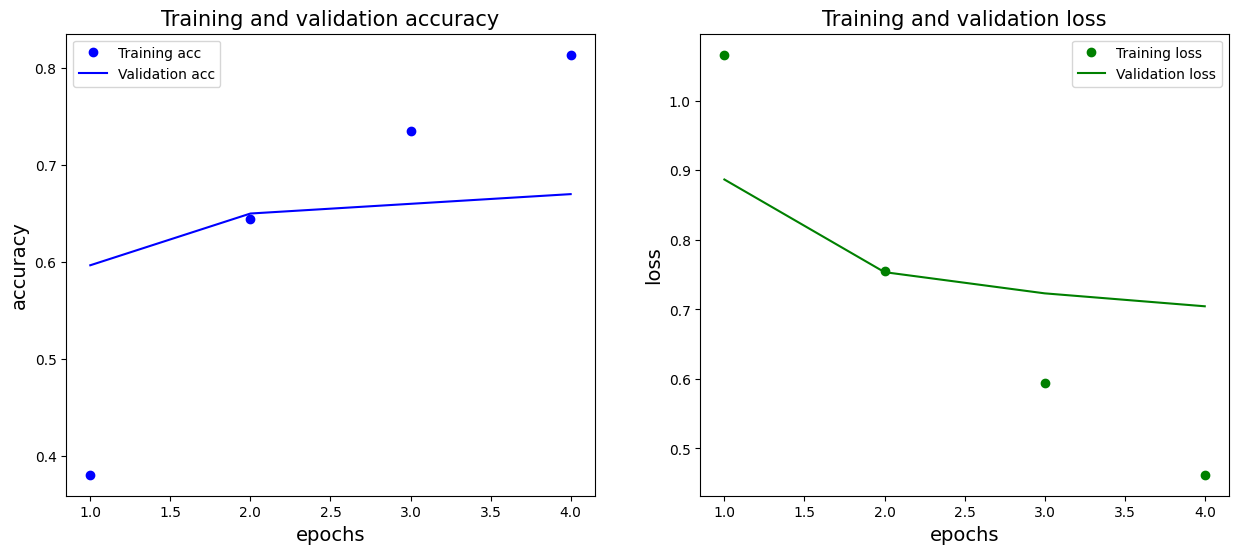

In [62]:
plot_loss_accuracy(r)

In [63]:
model.save('model_GRU_final.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.get_config()

In [65]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

model = None
r = None

model = load_model('model_GRU_final.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          325600    
                                                                 
 bidirectional (Bidirection  (None, None, 256)         115200    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 256)         296448    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, None, 256)         0         
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 256)         2

7. Analiza sentymentu

In [66]:
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

In [67]:
data5k.rename(columns={'targets':'label'}, inplace=True)
data5k.rename(columns={'Review':'text'}, inplace=True)
del data5k['Rating_class']
data5k.sample(3)

,text,label
11577,phone work 4 day french frie floor roach crawl...,0
15787,ok second time singapore hotel ok normal merid...,0
8327,"perfect location location location location , ...",1


In [68]:
from datasets import Dataset
dataset_ = Dataset.from_pandas(data5k)
dataset = dataset_.train_test_split(0.1)

In [69]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 2700
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 300
    })
})


In [70]:
model_checkpoint = 'microsoft/deberta-base'
batch_size = 128

In [71]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast = True)

In [72]:
tokenizer('recommend hotel reviewer actually stay hotel')

{'input_ids': [1, 43140, 1397, 2303, 37102, 888, 1095, 2303, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [73]:
def process(x):
  return tokenizer(x['text'])

train_ds = dataset['train'].map(process)
eval_ds = dataset['test'].map(process)

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (649 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [74]:
train_ds

Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2700
})

In [75]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.weight', 'classifier.bias', 'pooler.dense.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [76]:
!pip install -U accelerate==0.20.1 -q
#!pip install -U transformers

In [77]:
import transformers
#!pip install -qqq torch==2.0.1 --progress-bar off
#import accelerate 0.20.1

In [78]:
transformers.__version__, accelerate.__version__

('4.35.2', '0.20.3')

In [79]:
args = TrainingArguments(
    f'{model_checkpoint}_sentiment_analysis',
    evaluation_strategy  = 'epoch',
    save_strategy = 'epoch',
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    num_train_epochs  = 5,
    weight_decay  = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy'
)

In [80]:
from datasets import load_metric
import numpy as np

metric = load_metric('glue','sst2')

def compute_metrics(eval_preds):
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis = 1)
  return metric.compute(predictions = predictions, references = labels)

<ipython-input-80-211fb054b740>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('glue','sst2')
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [81]:
trainer = Trainer(
    model,
    args,
    train_dataset  = train_ds,
    eval_dataset = eval_ds,
    tokenizer = tokenizer,
    compute_metrics = compute_metrics
)

In [ ]:
trainer.evaluate([train_ds[0]])

In [ ]:
#trainer.train()

In [83]:
%load_ext tensorboard

In [84]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('logs/demo')

In [85]:
trainer.model

DebertaForSequenceClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (

In [90]:
import torch

text = data5k['text'].loc[9514]
inputs = tokenizer(text, return_tensors='pt')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

with torch.no_grad():
  outputs = model(input_ids=input_ids, attention_mask=attention_mask)
  logits = outputs.logits
  predictions = torch.argmax(logits, dim=-1)

if predictions.item() == 1:
  print("negative example")
elif predictions.item() == 2:
  print("neutral example")
else:
  print("positive example")

negative example


In [91]:
data5k['text'].loc[9514]

'bad hotel awful place dirty room rude staff desperatley bad breakfast , stay ,'

In [92]:
data.iloc[9514]

Review          bad hotel awful place dirty room rude staff de...
Rating_class                                             Negative
Name: 9514, dtype: object

8. Podsumowanie

Podczas analizy skupiłam sie na znalezieniu optymalnego modelu, który umożliwiłby poprawną klasyfikację sentymentu dotyczącego przekazanych opinii.

Spośród 5 stworzonych modeli wybrałam jeden, którego dokadność jest na poziomie  val_accuracy: 0.6700 a strata val_loss: 0.7045. Jest to model BiGRU, dla którego najlepszy wynik osiągnęłam w 4 epoce. w dalszym działaniu modelu dochodziło do jego przeuczenia.

Model w porównaniu z modelem BiLSTM osiągnął gorsze wyniki, dlatego do wykorzystania wiznesowego rekomendowałabym model BiLSTM.